## Hw 1-2

## Import libraries

In [ ]:
# Import libraries
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Use Colab env

In [ ]:
#Check device: GPU(cuda) or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Load dataset

In [ ]:
# dataset upload
# data augmentation
# data normalization
transform_train = transforms.Compose([ # train set loader
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_val = transforms.Compose([ # validation set loader
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


transform_test = transforms.Compose([ # test set loader
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
val_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_val)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# split the training set into training and validation sets
train_size = int(0.9 * len(train_set)) # use only 5000 images for validation
val_size = len(train_set) - train_size
train_set, valset = torch.utils.data.random_split(train_set, [train_size, val_size])

100%|██████████| 170M/170M [00:09<00:00, 17.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size= 128, shuffle=True) # use shuffle only for train
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

In [ ]:
# sample image plot
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
  image = image.clip(0, 1)
  return image

In [ ]:
CLASS_NAMES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

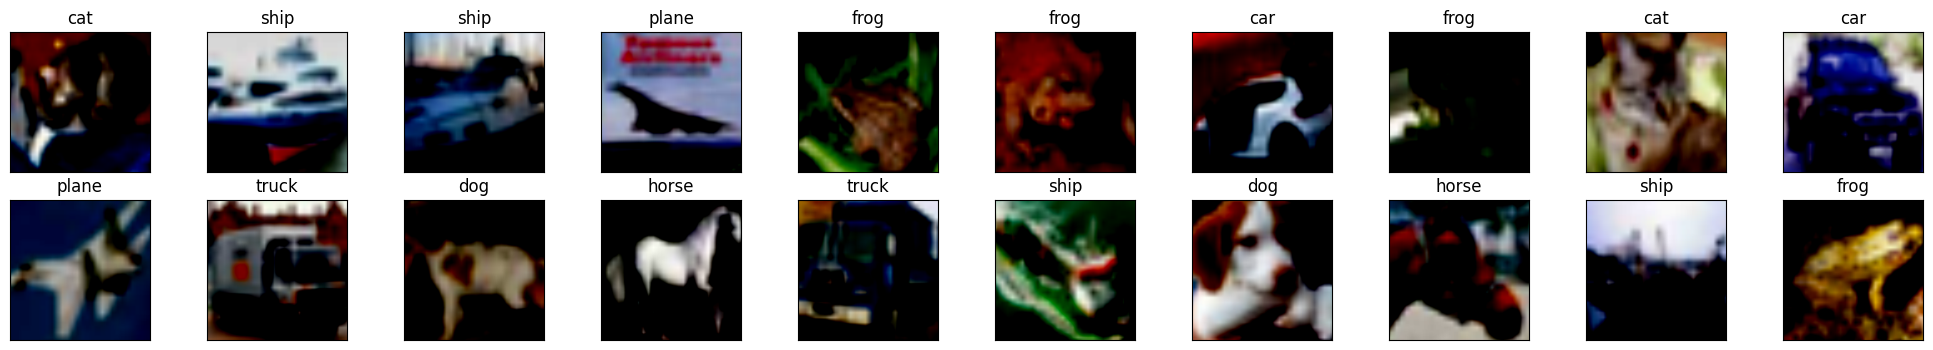

In [ ]:
# sample test image plot (normalized ones)
data_iter = iter(test_loader)
images, labels = next(data_iter)

fig = plt.figure(figsize=(25, 4))

for i in np.arange(20): # normalized test images
  # row 2 column 10
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[i]))
  ax.set_title(CLASS_NAMES[labels[i].item()])

## Define AlexNet

In [ ]:
# Define the AlexNet model
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# Initialize the model and optimizer
model = AlexNet().to(device) # use adam
optimizer = optim.Adam(model.parameters(), lr=0.001) # set learning rate as 0.001

## Check structure of the model

In [ ]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inp

## Train the model

In [ ]:
# Train the model
criterion = nn.CrossEntropyLoss()
num_epoch = 10
PATH =  "/content/drive/MyDrive/alexNet_pytorch.pt"
import math
total_batches = math.ceil(len(train_set) / 128)
total_steps = num_epoch * total_batches

In [ ]:
best_val_acc = 0.0  # initialize to lowest possible value
for epoch in range(num_epoch):
    # Train the model
    train_loss = 0.0
    train_acc = 0.0
    model.train()  # set model to training mode

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # zero out the gradients
        outputs = model(images) # forward pass
        loss = criterion(outputs, labels) # compute loss

        loss.backward() # backward pass
        optimizer.step() # update weights

        train_loss += loss.item() * images.size(0) # calculate training loss and accuracy
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)

        if (i + 1) % 100 == 0: # print status update every 100 batches
            print(f'Epoch [{epoch+1}/{num_epoch}], Step [{i+1}/{total_steps}], '
                  f'Training Loss: {train_loss / ((i+1)*128):.4f}, Training Accuracy: {train_acc / ((i+1)*128):.4f}')

    # Validate the model
    val_loss = 0.0
    val_acc = 0.0
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            # Move images and labels to device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)

            # Calculate validation loss and accuracy
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.data)

    # Calculate average losses and accuracies
    train_loss = train_loss / len(train_set)
    train_acc = train_acc / len(train_set)
    val_loss = val_loss / len(val_set)
    val_acc = val_acc / len(val_set)

    # Print epoch summary
    print(f'Epoch [{epoch+1}/{num_epoch}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), PATH)

Epoch [1/10], Step [100/3520], Training Loss: 2.3186, Training Accuracy: 0.1005
Epoch [1/10], Step [200/3520], Training Loss: 2.3107, Training Accuracy: 0.0995
Epoch [1/10], Step [300/3520], Training Loss: 2.3081, Training Accuracy: 0.0999
Epoch [1/10], Training Loss: 2.3073, Training Accuracy: 0.0992, Validation Loss: 2.3026, Validation Accuracy: 0.1000
Epoch [2/10], Step [100/3520], Training Loss: 2.3027, Training Accuracy: 0.1008
Epoch [2/10], Step [200/3520], Training Loss: 2.3027, Training Accuracy: 0.0995
Epoch [2/10], Step [300/3520], Training Loss: 2.3027, Training Accuracy: 0.0991
Epoch [2/10], Training Loss: 2.3027, Training Accuracy: 0.0983, Validation Loss: 2.3026, Validation Accuracy: 0.1000
Epoch [3/10], Step [100/3520], Training Loss: 2.3027, Training Accuracy: 0.0986
Epoch [3/10], Step [200/3520], Training Loss: 2.3027, Training Accuracy: 0.0995
Epoch [3/10], Step [300/3520], Training Loss: 2.3027, Training Accuracy: 0.0981
Epoch [3/10], Training Loss: 2.3027, Training 

## Test the model

In [ ]:
# Evaluate the model on the test set
correct = 0
total = 0
test_model = AlexNet().to(device)
test_model.load_state_dict(torch.load(PATH))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = test_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total)) # accuary for test images

<ipython-input-15-28cf1e8a30d7>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(PATH))


Accuracy of the network on the 10000 test images: 10 %


## Sample image plot

In [ ]:
# Function to plot images along with their predictions
def plot_predictions(images, labels, predictions):
    fig, axs = plt.subplots(1, len(images), figsize=(25, 4))
    for i in range(len(images)):
        image = images[i] / 2 + 0.5     # Unnormalize the image
        image = image.permute(1, 2, 0)   # Transpose to (height, width, channels)
        axs[i].imshow(image)
        axs[i].set_title(f"True: {CLASS_NAMES[labels[i]]}\nPred: {CLASS_NAMES[predictions[i]]}")
        axs[i].axis('off')
    plt.show()


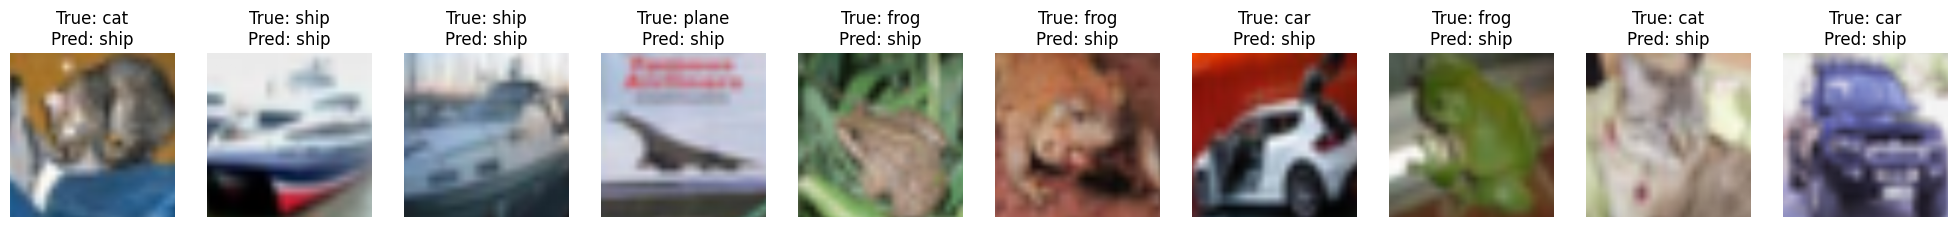

In [ ]:
# Get a batch of test images and their labels
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Move the images and labels to the device
images, labels = images.to(device), labels.to(device)
sample_images = images[:10] # 10 sample image
sample_labels = labels[:10]
# Make predictions on the batch of images
outputs = test_model(sample_images)
_, predicted = torch.max(outputs, 1)

# Plot the images and their predictions
plot_predictions(sample_images.cpu(), sample_labels.cpu(), predicted.cpu())

## Student 네트워크 정의 및 속도 비교 (HW3)

In [ ]:
# Student 네트워크 정의
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# Teacher 모델 초기화 및 가중치 불러오기
teacher_model = AlexNet().to(device)
teacher_model.load_state_dict(torch.load("/content/drive/MyDrive/alexNet_pytorch.pt"))
teacher_model.eval()

<ipython-input-19-f81de0d19985>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load("/content/drive/MyDrive/alexNet_pytorch.pt"))


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inp

In [ ]:
# Knowledge Distillation 학습 함수 정의
def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, alpha, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            # Soften the student logits by applying softmax first and log() second
            soft_targets = F.softmax(teacher_logits / T, dim=-1)
            soft_prob = F.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = alpha * soft_targets_loss + (1 - alpha) * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

In [ ]:
# 지식 증강를 사용하여 Student 모델 학습
student_model = StudentNet().to(device)
train_knowledge_distillation(teacher=teacher_model, student=student_model, train_loader=train_loader, epochs=10, learning_rate=0.001, T=3.0, alpha=0.7, device=device)

# 학습된 student 모델 저장
torch.save(student_model.state_dict(), "/content/drive/MyDrive/studentNet_pytorch.pt")

Epoch 1/10, Loss: 0.6395018877969547
Epoch 2/10, Loss: 0.5884856884791092
Epoch 3/10, Loss: 0.5663791104135188
Epoch 4/10, Loss: 0.5522156494923613
Epoch 5/10, Loss: 0.5444264279847796
Epoch 6/10, Loss: 0.537891800430688
Epoch 7/10, Loss: 0.5296229131689126
Epoch 8/10, Loss: 0.5258941445499659
Epoch 9/10, Loss: 0.5205554623495449
Epoch 10/10, Loss: 0.5162868548015301


In [ ]:
# 지식 증강 없이 Student 모델 학습 함수 정의
def train_student_no_distillation(student, train_loader, epochs, learning_rate, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the student model
            student_logits = student(inputs)

            # Calculate the true label loss
            loss = ce_loss(student_logits, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"[No Distillation] Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")


In [ ]:
# 지식 증강 없이 Student 모델 학습
student_model_no_distill = StudentNet().to(device)
train_student_no_distillation(student=student_model_no_distill, train_loader=train_loader, epochs=10, learning_rate=0.001, device=device)

# 학습된 student 모델 (지식 증류 없이) 저장
torch.save(student_model_no_distill.state_dict(), "/content/drive/MyDrive/studentNet_no_distill_pytorch.pt")

[No Distillation] Epoch 1/10, Loss: 1.7881298712031408
[No Distillation] Epoch 2/10, Loss: 1.3793063939295032
[No Distillation] Epoch 3/10, Loss: 1.1890674683858047
[No Distillation] Epoch 4/10, Loss: 1.0730289906602015
[No Distillation] Epoch 5/10, Loss: 1.0057904332537542
[No Distillation] Epoch 6/10, Loss: 0.9412259193645283
[No Distillation] Epoch 7/10, Loss: 0.8821496684104204
[No Distillation] Epoch 8/10, Loss: 0.8483275446024808
[No Distillation] Epoch 9/10, Loss: 0.8122722235592928
[No Distillation] Epoch 10/10, Loss: 0.7935015965591777


In [ ]:
# 두 모델의 정확도 및 추론 속도 비교
import time

# 평가 함수 정의
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# 추론 속도 측정 함수 정의
def measure_inference_time(model, loader):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            model(images)
    end_time = time.time()
    return end_time - start_time


In [26]:
# 지식 증강 사용한 모델 평가
distill_accuracy = evaluate_model(student_model, test_loader)
distill_inference_time = measure_inference_time(student_model, test_loader)

# 지식 증강 사용하지 않은 모델 평가
no_distill_accuracy = evaluate_model(student_model_no_distill, test_loader)
no_distill_inference_time = measure_inference_time(student_model_no_distill, test_loader)

In [27]:
# 결과 출력
print(f"Student Model with Distillation - Accuracy: {distill_accuracy:.2f}%, Inference Time: {distill_inference_time:.2f} seconds")
print(f"Student Model without Distillation - Accuracy: {no_distill_accuracy:.2f}%, Inference Time: {no_distill_inference_time:.2f} seconds")

Student Model with Distillation - Accuracy: 70.99%, Inference Time: 21.04 seconds
Student Model without Distillation - Accuracy: 73.97%, Inference Time: 20.79 seconds
